<!--<badge>--><a href="https://colab.research.google.com/github/huggingface/workshops/blob/main/europython-2022/01-transformers-tour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# A 🤗 tour of transformer applications

In this notebook we take a tour around transformers applications. The transformer architecture is very versatile and allows us to perform many NLP tasks with only minor modifications. For this reason they have been applied to a wide range of NLP tasks such as classification, named entity recognition, or translation.

## Pipeline

We experiment with models for these tasks using the high-level API called pipeline. The pipeline takes care of all preprocessing and returns cleaned up predictions. The pipeline is primarily used for inference where we apply fine-tuned models to new examples.

<img src="images/pipeline.png" alt="Alt text that describes the graphic" title="Title text" width=800>

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('1pedAIvTWXk')

## Setup

Before we start we need to make sure we have the transformers library installed as well as the sentencepiece tokenizer which we'll need for some models.

In [ ]:
%%capture
!pip install transformers
!pip install sentencepiece

Furthermore, we create a textwrapper to format long texts nicely.

In [1]:
import textwrap
wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

## Classification

We start by setting up an example text that we would like to analyze with a transformer model. This looks like your standard customer feedback from a transformer:

In [2]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

print(wrapper.fill(text))

Dear Amazon, last week I ordered an Optimus Prime action figure from your online
store in Germany. Unfortunately, when I opened the package, I discovered to my
horror that I had been sent an action figure of Megatron instead! As a lifelong
enemy of the Decepticons, I hope you can understand my dilemma. To resolve the
issue, I demand an exchange of Megatron for the Optimus Prime figure I ordered.
Enclosed are copies of my records concerning this purchase. I expect to hear
from you soon. Sincerely, Bumblebee.


One of the most common tasks in NLP and especially when dealing with customer texts is _sentiment analysis_. We would like to know if a customer is satisfied with a service or product and potentially aggregate the feedback across all customers for reporting.

For text classification the model gets all the inputs and makes a single prediction as shown in the following example:

<img src="images/clf_arch.png" alt="Alt text that describes the graphic" title="Title text" width=600>

We can achieve this by setting up a `pipeline` object which wraps a transformer model. When initializing we need to specify the task. Sentiment analysis is a subfield of text classification where a single label is given to a 

In [3]:
from transformers import pipeline

sentiment_pipeline = pipeline('text-classification')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
2022-07-07 16:35:45.867275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:35:45.873766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:35:45.874797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:35:45.876266: I tensorflow/core/platform/cpu_featur

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

You can see a warning message: we did not specify in the pipeline which model we would like to use. In that case it loads a default model. The `distilbert-base-uncased-finetuned-sst-2-english` model is a small BERT variant trained on [SST-2](https://paperswithcode.com/sota/sentiment-analysis-on-sst-2-binary) which is a sentiment analysis dataset.

You'll notice that the first time you execute the model a download is executed. The model is downloaded from the 🤗 Hub! The second time the cached model will be used.

Now we are ready to run our example through pipeline and look at some predictions:

In [4]:
sentiment_pipeline(text)

[{'label': 'NEGATIVE', 'score': 0.9015461802482605}]

The model predicts negative sentiment with a high confidence which makes sense. You can see that the pipeline returns a list of dicts with the predictions. We can also pass several texts at the same time in which case we would get several dicts in the list for each text one.

## Named entity recognition

Let's see if we can do something a little more sophisticated. Instead of just finding the overall sentiment let's see if we can extract named entities such as organizations, locations, or individuals from the text. This task is called named entity recognition (NER). Instead of predicting just a class for the whole text a class is predicted for each token, thus this task belongs to the category of token classification:

<img src="images/ner_arch.png" alt="Alt text that describes the graphic" title="Title text" width=550>

Again, we just load a pipeline for the NER task without specifying a model. This will load a default BERT model that has been trained on the [CoNLL-2003](https://huggingface.co/datasets/conll2003).

In [ ]:
ner_pipeline = pipeline('ner')

When we pass our text through the model we get a long list of dicts: each dict corresponds to one detected entity. Since multiple tokens can correspond to a a single entity we can apply an aggregation strategy that merges entities if the same class appears in consequtive tokens.

In [ ]:
entities = ner_pipeline(text, aggregation_strategy="simple")
print(entities)

Let's clean the outputs a bit up:

In [ ]:
for entity in entities:
    print(f"{entity['word']}: {entity['entity_group']} ({entity['score']:.2f})")

It seems that the model found most of the named entities but was confused about the class of the transformer characters. This is no surprise since the original dataset probably did not contain many transformer characters. For this reason it makes sense to further fine-tune a model on your on dataset!

## Question-answering

We have now seen an example of text and token classification using transformers. However, there are more interesting tasks we can use transformers for. One of them is question-answering. In this task the model is given a question and a context and needs to find the answer to the question within the context. This problem can be rephrased into a classification problem: For each token the model needs to predict whether it is the start or the end of the answer. In the end we can extract the answer by looking at the span between the token with the highest start probability and highest end probability:

<img src="images/qa_arch.png" alt="Alt text that describes the graphic" title="Title text" width=600>

You can imagine that this requires quite a bit of pre- and post-processing logic. Good thing that the pipeline takes care of all that!

In [ ]:
qa_pipeline = pipeline("question-answering")

This default model is trained on the canonical [SQuAD dataset](https://huggingface.co/datasets/squad). Let's see if we can ask it what the customer wants:

In [ ]:
question = "What does the customer want?"

outputs = qa_pipeline(question=question, context=text)
outputs

Awesome, that sounds about right!

## Summarization

Let's see if we can go beyond these natural language understanding tasks (NLU) where BERT excels and delve into the generative domain. Note that generation is much more expensive since we usually generate one token at a time and need to run this several times.

<img src="images/gen_steps.png" alt="Alt text that describes the graphic" title="Title text" width=600>

A popular task involving generation is summarization. Let's see if we can use a transformer to generate a summary for us:

In [ ]:
summarization_pipeline = pipeline("summarization")

This model is trained was trained on the [CNN/Dailymail dataset](https://huggingface.co/datasets/cnn_dailymail) to summarize news articles.

In [ ]:
outputs = summarization_pipeline(text, max_length=45, clean_up_tokenization_spaces=True)
print(wrapper.fill(outputs[0]['summary_text']))

## Translation

But what if there is no model in the language of my data? You can still try to translate the text. The Helsinki NLP team has provided over 1000 language pair models for translation. Here we load one that translates English to German:

In [ ]:
translator = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")

Let's translate the a text to German:

In [ ]:
text = 'At the EuroPython conference in Dublin we gave an introduction about Transformers.'

In [ ]:
outputs = translator(text, clean_up_tokenization_spaces=True)
print(wrapper.fill(outputs[0]['translation_text']))

Barring a little bit of questionable grammar, this translation is pretty close, and certainly completely understandable for a German speaker!

## Visual Question Answering

Remember that transformers aren't just for NLP! They are also state-of-the-art for audio and vision tasks. To demonstrate this, let's use a "multimodal" pipeline. A multimodel model handles multiple 'modalities' of data at once, like images, text or audio. In this case, we will show our model an image, and ask it questions in natural language. This one is very recent and only supports PyTorch right now, but we'll have a port very soon!

In [5]:
visual_qa = pipeline("visual-question-answering")

No model was supplied, defaulted to dandelin/vilt-b32-finetuned-vqa and revision 4355f59 (https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/132k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/449M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

Let's download an image, then display it in our notebook so we can make sure we got the right one.

In [6]:
!wget https://www.petplace.com/static/9045aba2c9629a08b8178258fcac04e4/98569/Multiple-Cats.jpg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2022-07-07 16:37:21--  https://www.petplace.com/static/9045aba2c9629a08b8178258fcac04e4/98569/Multiple-Cats.jpg
Resolving www.petplace.com (www.petplace.com)... 20.106.240.131
Connecting to www.petplace.com (www.petplace.com)|20.106.240.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239123 (234K) [image/jpeg]
Saving to: ‘Multiple-Cats.jpg’

Multiple-Cats.jpg   100%[===================>] 233.52K  1014KB/s    in 0.2s    

2022-07-07 16:37:22 (1014 KB/s) - ‘Multiple-Cats.jpg’ saved [239123/239123]



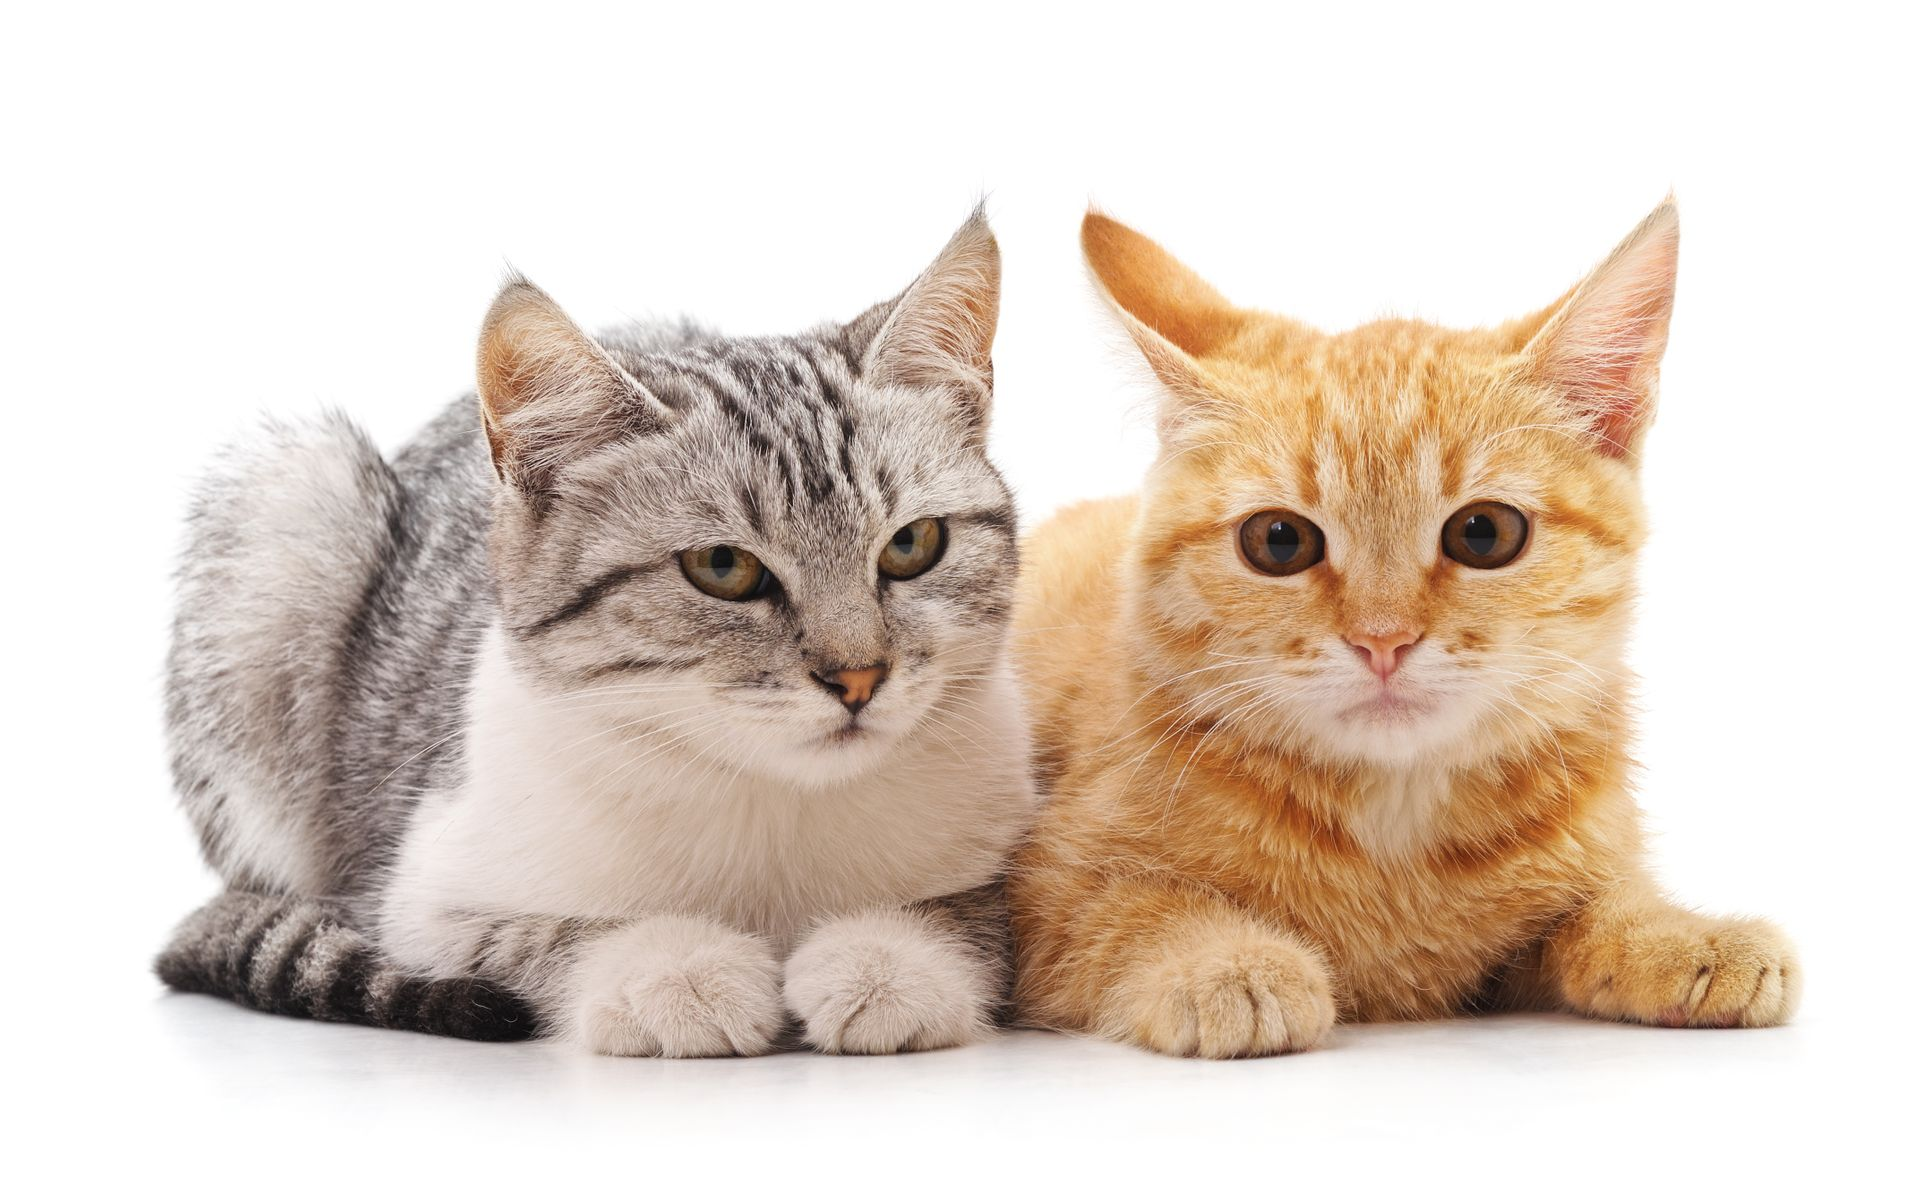

In [7]:
from IPython.display import Image
Image('Multiple-Cats.jpg')

In [9]:
visual_qa(image="Multiple-Cats.jpg", question="What animal is in this picture?", top_k=3)

[{'score': 0.9711247682571411, 'answer': 'cat'},
 {'score': 0.19314900040626526, 'answer': 'cats'},
 {'score': 0.04180370271205902, 'answer': 'kitten'}]

In [11]:
visual_qa(image="Multiple-Cats.jpg", question="How many cats are there?", top_k=3)

[{'score': 0.9467284083366394, 'answer': '2'},
 {'score': 0.06492548435926437, 'answer': '1'},
 {'score': 0.016972273588180542, 'answer': '3'}]

## Custom Model

As a last example let's have a look at a cool application showing the versatility of transformers: zero-shot classification. In zero-shot classification the model receives a text and a list of candidate labels and determines which labels are compatible with the text. Instead of having fixed classes this allows for flexible classification without any labelled data! Usually this is a good first baseline!

In [ ]:
zero_shot_classifier = pipeline("zero-shot-classification",
                                model="vicgalle/xlm-roberta-large-xnli-anli")

Let's have a look at an example:

In [ ]:
text = '東京のMLTワークショップで,トランスフォーマーについて紹介しました.'
classes = ['Japan', 'Switzerland', 'USA']

In [ ]:
zero_shot_classifier(text, classes)

This seems to have worked really well on this short example. Naturally, for longer and more domain specific examples this approach might suffer.

## More pipelines

There are many more pipelines that you can experiment with. Look at the following list for an overview:

In [ ]:
from transformers import pipelines
for task in pipelines.SUPPORTED_TASKS:
    print(task)

Transformers not only work for NLP but can also be applied to other modalities. Let's have a look at a few.

### Audio

Another promising area is audio processing. Especially Speech2Text there have been some promising advancements recently. See for example the [wav2vec2 model](https://huggingface.co/facebook/wav2vec2-base-960h):

<img src="images/speech2text.png" alt="Alt text that describes the graphic" title="Title text" width=400>

### Table QA

Finally, a lot of real world data is still in form of tables. Being able to query tables is very useful and with [TAPAS](https://huggingface.co/google/tapas-large-finetuned-wtq) you can do tabular question-answering:

<img src="images/tapas.png" alt="Alt text that describes the graphic" title="Title text" width=400>

## Cache

Whenever we load a new model from the Hub it is cached on the machine you are running on. If you run these examples on Colab this is not an issue since the persistent storage will be cleaned after your session anyway. However, if you run this notebook on your laptop you might have just filled several GB of your hard drive. By default the cache is saved in the folder `~/.cache/huggingface/transformers`. Make sure to clear it from time to time if your hard drive starts to fill up.